# Diurnal variations of wind 


This notebook look into the wind velocity parameters from the model outputs 

In [1]:
import xarray as xr
from pathlib import Path
import pandas as pd
import intake
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import easygems.healpix as egh
import numpy as np
from functools import partial
from matplotlib import cm

In [24]:
from dask.distributed import Client

In [26]:
client=Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 2
Total threads: 2,Total memory: 9.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40905,Workers: 2
Dashboard: /proxy/8787/status,Total threads: 2
Started: Just now,Total memory: 9.00 GiB
Comm: tcp://127.0.0.1:43369,Total threads: 1
Dashboard: /proxy/42181/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:43857,


In [2]:
data_2d_z2 = "/g/data/qx55/uk_node/glm.n2560_RAL3p3/data.healpix.PT1H.z6.zarr" #PT1H is hourly data
ds = xr.open_zarr(data_2d_z2)
ds = ds.pipe(partial(egh.attach_coords))
ds

<xarray.Dataset> Size: 49GB
Dimensions:  (time: 10489, cell: 49152)
Coordinates:
  * time     (time) datetime64[ns] 84kB 2020-01-20 ... 2021-04-01
    crs      int64 8B 0
  * cell     (cell) int64 393kB 0 1 2 3 4 5 ... 49147 49148 49149 49150 49151
    lat      (cell) float64 393kB 0.5968 1.194 1.194 ... -1.194 -1.194 -0.5968
    lon      (cell) float64 393kB 45.0 45.7 44.3 45.0 ... 315.7 314.3 315.0
Data variables: (12/24)
    clivi    (time, cell) float32 2GB dask.array<chunksize=(64, 16384), meta=np.ndarray>
    clt      (time, cell) float32 2GB dask.array<chunksize=(64, 16384), meta=np.ndarray>
    clwvi    (time, cell) float32 2GB dask.array<chunksize=(64, 16384), meta=np.ndarray>
    hflsd    (time, cell) float32 2GB dask.array<chunksize=(64, 16384), meta=np.ndarray>
    hfssd    (time, cell) float32 2GB dask.array<chunksize=(64, 16384), meta=np.ndarray>
    huss     (time, cell) float32 2GB dask.array<chunksize=(64, 16384), meta=np.ndarray>
    ...       ...
    rsut     (time, cell) float32 2GB dask.array<chunksize=(64, 16384), meta=np.ndarray>
    rsutcs   (time, cell) float32 2GB dask.array<chunksize=(64, 16384), meta=np.ndarray>
    tas      (time, cell) float32 2GB dask.array<chunksize=(64, 16384), meta=np.ndarray>
    ts       (time, cell) float32 2GB dask.array<chunksize=(64, 16384), meta=np.ndarray>
    uas      (time, cell) float32 2GB dask.array<chunksize=(64, 16384), meta=np.ndarray>
    vas      (time, cell) float32 2GB dask.array<chunksize=(64, 16384), meta=np.ndarray>
Attributes:
    Met Office DYAMOND3 simulations:  A group of experiments have been conduc...
    bounds:                           {'lower_left_lat': -90, 'lower_left_lon...
    latitiude_convention:             [-90, 90]
    longitude_convention:             [0, 360]
    regional:                         False
    simulation:                       glm.n2560_RAL3p3
    simulation_description:           The MetUM uses a regular lat-lon grid, ...

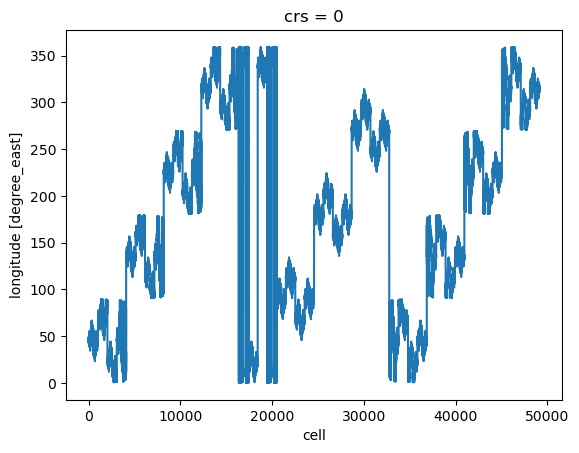

In [3]:
ds.lon.plot()

In [4]:
# slect the wind data u and v components
u1=ds.uas.sel(time=slice("2020-04-01", "2020-09-30"))
u2=ds.uas.sel(time=slice("2020-10-01", "2021-04-01"))
v1=ds.vas.sel(time=slice("2020-04-01", "2020-09-30"))
v2=ds.vas.sel(time=slice("2020-10-01", "2021-04-01"))
velocity1 = (u1**2 + v1**2)**0.5
velocity2 = (u2**2 + v2**2)**0.5

### average functions

In [5]:
def monthly_hourly_average(data):
    """
    Compute the time average for each hour of the day across all days, separately for each month.
    """
    # Group by month, then by hour, and compute the mean over time within each group
    monthly_hourly_avg = data.groupby('time.month').apply(lambda x: x.groupby('time.hour').mean('time'))
    
    return monthly_hourly_avg


In [6]:
def hourly_average(data):
    """
    Compute the time average for each hour of the day across all days for whole time period
    """
    # Group by month, then by hour, and compute the mean over time within each group
    hourly_avg = data.groupby('time.hour').mean('time')
    
    return hourly_avg


In [7]:
# get the average velocities 
hourly_avg_velocity1 = hourly_average(velocity1)
hourly_avg_velocity2 = hourly_average(velocity2)

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Only found a single cohort. 'map-reduce' is preferred.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=map-reduce
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is True
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Only found a single cohort. 'map-reduce' is preferred.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=map-reduce
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is True


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/indexing.py:1620: PerformanceWarning: Slicing with an out-of-order index is generating 449 times more chunks
  return self.array[key]


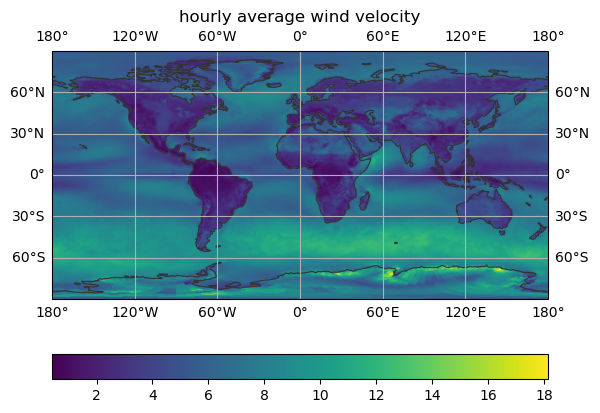

In [8]:
# Plotting lat/lon values over the grid
projection=ccrs.PlateCarree(central_longitude=0.0)
ax = egh.create_geoaxis(add_coastlines=True,projection=projection)
im = egh.healpix_show(hourly_avg_velocity1.isel(hour=6), ax=ax, add_coastlines=True)
ax.set_title(f'hourly average wind velocity')
ax.gridlines(draw_labels=True)
fig=ax.get_figure()
fig.colorbar(im,orientation='horizontal')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/indexing.py:1620: PerformanceWarning: Slicing with an out-of-order index is generating 118 times more chunks
  return self.array[key]


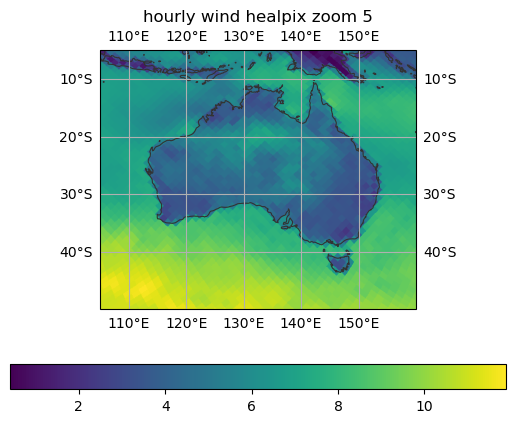

In [9]:
# Plotting the above, over Australia

# Note - we still have to use the egh wrapper functions to plot the healpix gridded data
# onto a lat/lon grid
projection = ccrs.PlateCarree(central_longitude=0)

ax = egh.create_geoaxis(add_coastlines=True,projection=projection)

ax.set_extent([105, 160,-50, -5], crs=ccrs.PlateCarree())
im = egh.healpix_show(hourly_avg_velocity1.isel(hour=0), ax=ax)
#ax.coastlines()
ax.set_title(f'hourly wind healpix zoom 5')
ax.gridlines(draw_labels=True)
fig=ax.get_figure()
fig.colorbar(im,orientation='horizontal')

### calculate the max min values and amplitud of the diurnal variations

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/indexing.py:1620: PerformanceWarning: Slicing with an out-of-order index is generating 449 times more chunks
  return self.array[key]


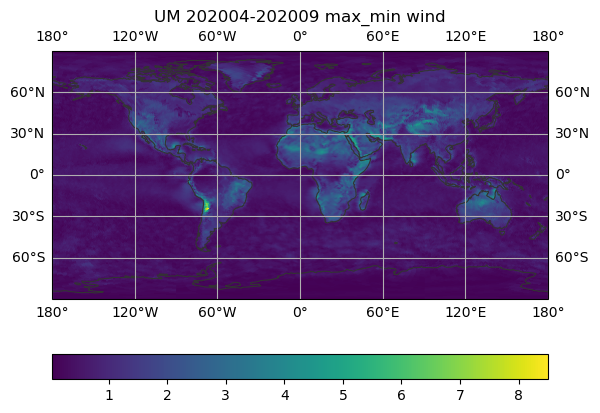

In [10]:
monthly_max=hourly_avg_velocity1.max(dim='hour') #looking at max values for each months 

#taking the maximum and minimums for whole dataset across hours and months. each cell has one value
avg_max = hourly_avg_velocity1.max(dim='hour')
avg_min = hourly_avg_velocity1.min(dim='hour')

# getting the amplitude
max_min_diff = avg_max - avg_min

#plot

projection=ccrs.PlateCarree(central_longitude=0.0)
ax = egh.create_geoaxis(add_coastlines=True,projection=projection)
im = egh.healpix_show(max_min_diff, ax=ax, add_coastlines=True)
ax.set_title(f'UM 202004-202009 max_min wind')
ax.gridlines(draw_labels=True)
fig=ax.get_figure()
fig.colorbar(im,orientation='horizontal')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/indexing.py:1620: PerformanceWarning: Slicing with an out-of-order index is generating 449 times more chunks
  return self.array[key]


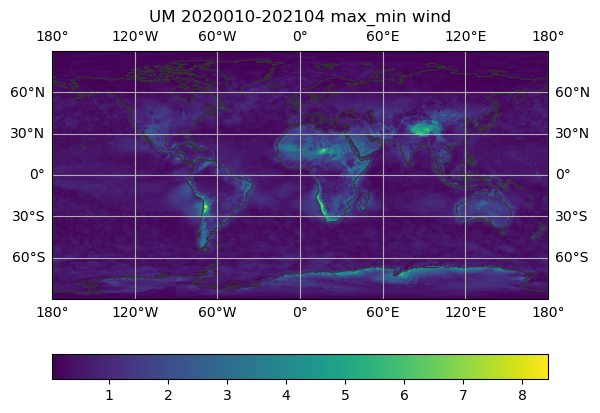

In [11]:
monthly_max=hourly_avg_velocity2.max(dim='hour') #looking at max values for each months 

#taking the maximum and minimums for whole dataset across hours. each cell has one value
avg_max = hourly_avg_velocity2.max(dim='hour')
avg_min = hourly_avg_velocity2.min(dim='hour')

# getting the amplitude
max_min_diff2 = avg_max - avg_min

#plot

projection=ccrs.PlateCarree(central_longitude=0.0)
ax = egh.create_geoaxis(add_coastlines=True,projection=projection)
im = egh.healpix_show(max_min_diff2, ax=ax, add_coastlines=True)
ax.set_title(f'UM 2020010-202104 max_min wind')
ax.gridlines(draw_labels=True)
fig=ax.get_figure()
fig.colorbar(im,orientation='horizontal')

### picking the timestamp for max valocity when hourly averages are done monthly

In [ ]:
#  Reshape to stack (month, hour) into a single dimension
uas_stacked = hourly_avg_velocity1.stack(time_combo=("month", "hour"))
uas_stacked

In [ ]:
# Find the index of the max along the combined dimension, for each cell. this is only an id
max_idx = uas_stacked.argmax(dim="time_combo")
max_idx.values

In [ ]:
# this function unravvel the id of the maximum value to the hour and month.
month_indices, hour_indices = np.unravel_index(max_idx.values, (12, 24)) #

In [ ]:
# Also get the max value for each cell
max_val = uas_stacked.max(dim="time_combo")

In [ ]:
# save the max value and the timestamps into a new dataset
max_values_ds = xr.Dataset({
    "max_value": (["cell"], max_val.values),
    "month_of_max": (["cell"], month_indices),
    "hour_of_max": (["cell"], hour_indices),
})

In [ ]:
max_values_ds

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/numpy/core/numeric.py:330: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


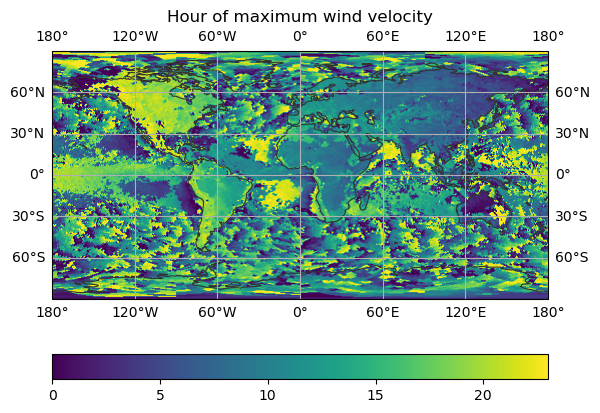

In [72]:
projection=ccrs.PlateCarree(central_longitude=0.0)
ax = egh.create_geoaxis(add_coastlines=True,projection=projection)
im = egh.healpix_show(max_values_ds.hour_of_max, ax=ax, add_coastlines=True)
ax.set_title(f'Hour of maximum wind velocity')
ax.gridlines(draw_labels=True)
fig=ax.get_figure()
fig.colorbar(im,orientation='horizontal')

In [ ]:
projection=ccrs.PlateCarree(central_longitude=0.0)
ax = egh.create_geoaxis(add_coastlines=True,projection=projection)
im = egh.healpix_show(max_values_ds.hour_of_max, ax=ax, add_coastlines=True,cmap=hsv)
ax.set_title(f'Hour of maximum wind velocity')
ax.gridlines(draw_labels=True)
fig=ax.get_figure()
fig.colorbar(im,orientation='horizontal')

### hour of maximum velocity

In [ ]:
# Find the index of the max along the combined dimension, for each cell. this is only an id
max_idx1 = hourly_avg_velocity1.argmax(dim="hour")
max_val1 = hourly_avg_velocity1.max(dim='hour')

In [31]:
# Save the max value, hour of max, and include longitude as a coordinate
max_values_ds1 = xr.Dataset({
    "max_value": ("cell", max_val1.values),
    "hour_of_max": ("cell", max_idx1.values),
})

max_values_ds1

<xarray.Dataset> Size: 590kB
Dimensions:      (cell: 49152)
Dimensions without coordinates: cell
Data variables:
    max_value    (cell) float32 197kB 8.296 8.421 7.753 ... 6.382 4.688 6.28
    hour_of_max  (cell) int64 393kB 21 21 13 13 19 20 12 ... 13 14 15 13 19 22

In [ ]:
max_values_ds1

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/numpy/core/numeric.py:330: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


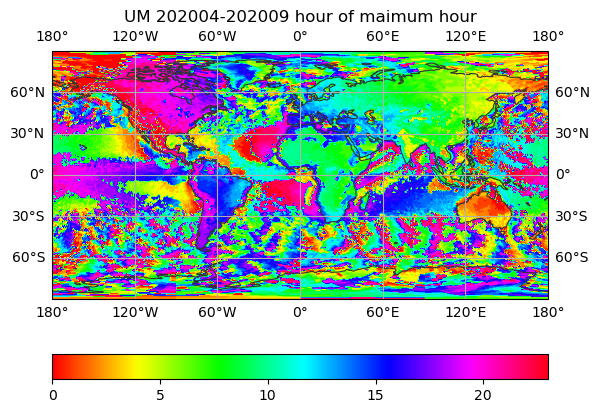

In [15]:
projection=ccrs.PlateCarree(central_longitude=0.0)
ax = egh.create_geoaxis(add_coastlines=True,projection=projection)
im = egh.healpix_show(max_values_ds1.hour_of_max, ax=ax, add_coastlines=True,cmap=cm.hsv)
ax.set_title(f'UM 202004-202009 hour of maimum hour')
ax.gridlines(draw_labels=True)
fig=ax.get_figure()
fig.colorbar(im,orientation='horizontal')

In [29]:
# Find the index of the max along the combined dimension, for each cell. this is only an id
max_idx2 = hourly_avg_velocity2.argmax(dim="hour")
max_val2 = hourly_avg_velocity2.max(dim='hour')

# save the max value and the timestamps into a new dataset
max_values_ds2 = xr.Dataset({
    "max_value": max_val2,
    "hour_of_max":  max_idx2,
})
max_values_ds2

<xarray.Dataset> Size: 2MB
Dimensions:      (cell: 49152)
Coordinates:
    crs          int64 8B 0
  * cell         (cell) int64 393kB 0 1 2 3 4 ... 49147 49148 49149 49150 49151
    lat          (cell) float64 393kB 0.5968 1.194 1.194 ... -1.194 -0.5968
    lon          (cell) float64 393kB 45.0 45.7 44.3 45.0 ... 315.7 314.3 315.0
Data variables:
    max_value    (cell) float32 197kB dask.array<chunksize=(16384,), meta=np.ndarray>
    hour_of_max  (cell) int64 393kB dask.array<chunksize=(16384,), meta=np.ndarray>

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/numpy/core/numeric.py:330: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/indexing.py:1620: PerformanceWarning: Slicing with an out-of-order index is generating 449 times more chunks
  return self.array[key]


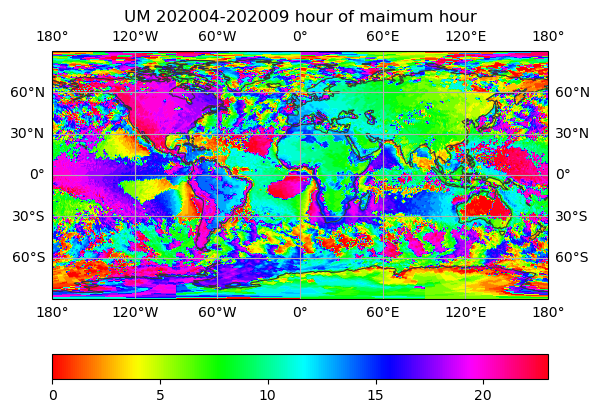

In [30]:
projection=ccrs.PlateCarree(central_longitude=0.0)
ax = egh.create_geoaxis(add_coastlines=True,projection=projection)
im = egh.healpix_show(max_values_ds2.hour_of_max, ax=ax, add_coastlines=True,cmap=cm.hsv)
ax.set_title(f'UM 202004-202009 hour of maimum hour')
ax.gridlines(draw_labels=True)
fig=ax.get_figure()
fig.colorbar(im,orientation='horizontal')

### convert to the local time zone

In [32]:
max_values_ds2

<xarray.Dataset> Size: 2MB
Dimensions:      (cell: 49152)
Coordinates:
    crs          int64 8B 0
  * cell         (cell) int64 393kB 0 1 2 3 4 ... 49147 49148 49149 49150 49151
    lat          (cell) float64 393kB 0.5968 1.194 1.194 ... -1.194 -0.5968
    lon          (cell) float64 393kB 45.0 45.7 44.3 45.0 ... 315.7 314.3 315.0
Data variables:
    max_value    (cell) float32 197kB dask.array<chunksize=(16384,), meta=np.ndarray>
    hour_of_max  (cell) int64 393kB dask.array<chunksize=(16384,), meta=np.ndarray>

In [43]:
def convert_to_local_time(data, longitude):
    """
    Convert time steps to local times based on longitudes.

    Parameters:
        data (xarray.DataArray): The input data with a 'time' coordinate as integers (0-23).
        longitude (xarray.DataArray or numpy array): The longitudes corresponding to the data.

    Returns:
        xarray.DataArray: The data with time converted to local times as integers.
    """
    # Calculate the time offset in hours based on longitude
    time_offset = longitude / 15.0  # 15 degrees per hour

    # Apply the time offset to convert to local time
    local_time = (data.hour_of_max + time_offset).astype(int) % 24  # Ensure times wrap around 24 hours

    # Handle negative times (e.g., -1 becomes 23)
    local_time = xr.where(local_time < 0, local_time + 24, local_time)

    # Assign the local time back to the data
    data['time'] = local_time

    return data

In [44]:
time_converted_max_values_ds2 = convert_to_local_time(max_values_ds2, max_values_ds2.lon)

In [45]:
time_converted_max_values_ds2

<xarray.Dataset> Size: 2MB
Dimensions:      (cell: 49152)
Coordinates:
    crs          int64 8B 0
  * cell         (cell) int64 393kB 0 1 2 3 4 ... 49147 49148 49149 49150 49151
    lat          (cell) float64 393kB 0.5968 1.194 1.194 ... -1.194 -0.5968
    lon          (cell) float64 393kB 45.0 45.7 44.3 45.0 ... 315.7 314.3 315.0
    time         (cell) int64 393kB dask.array<chunksize=(16384,), meta=np.ndarray>
Data variables:
    max_value    (cell) float32 197kB dask.array<chunksize=(16384,), meta=np.ndarray>
    hour_of_max  (cell) int64 393kB dask.array<chunksize=(16384,), meta=np.ndarray>

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/numpy/core/numeric.py:330: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/indexing.py:1620: PerformanceWarning: Slicing with an out-of-order index is generating 449 times more chunks
  return self.array[key]


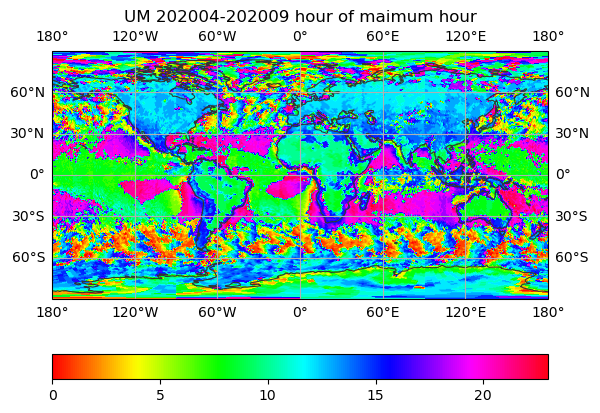

In [46]:
projection=ccrs.PlateCarree(central_longitude=0.0)
ax = egh.create_geoaxis(add_coastlines=True,projection=projection)
im = egh.healpix_show(max_values_ds2.time, ax=ax, add_coastlines=True,cmap=cm.hsv)
ax.set_title(f'UM 202004-202009 hour of maimum hour')
ax.gridlines(draw_labels=True)
fig=ax.get_figure()
fig.colorbar(im,orientation='horizontal')

In [ ]:
from matplotlib.colors import ListedColormap, BoundaryNorm


# Create discrete colormap with 24 colors from HSV
cmap = ListedColormap(cm.hsv(np.linspace(0, 1, 24)))
bounds = np.arange(25)  # 0 to 24, to create 24 bins
norm = BoundaryNorm(bounds, cmap.N)

# Set up projection and plot
projection = ccrs.PlateCarree(central_longitude=0.0)
ax = egh.create_geoaxis(add_coastlines=True, projection=projection)
im = egh.healpix_show(max_values_ds2.hour_of_max, ax=ax, cmap=cmap, norm=norm, add_coastlines=True)

# Plot styling
ax.set_title('UM 202004–202009 Hour of Maximum Wind Velocity')
ax.gridlines(draw_labels=True)

# Add colorbar with 24 ticks (0 to 23)
fig = ax.get_figure()
cbar = fig.colorbar(im, orientation='horizontal', ticks=np.arange(24))
cbar.set_label("Hour of Day")

plt.show()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/numpy/core/numeric.py:330: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/indexing.py:1620: PerformanceWarning: Slicing with an out-of-order index is generating 449 times more chunks
  return self.array[key]
